# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, Constant)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\Martijn Ras\AppData\Local\Programs\Python\Python38\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Martijn Ras\AppData\Local\Programs\Python\Python38\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
## for testing

print(PredPrey())

{'TIME': array([[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02]]), 'predators': array([[20.        , 20.2       , 20.40136875, ..., 37.69187459,
        37.72581658, 37.75505957]]), 'prey': array([[50.        , 49.9375    , 49.87133281, ..., 31.8010242 ,
        31.55029052, 31.30113215]])}


# Setup Excel model

In [2]:
## excel

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import (RealParameter, TimeSeriesOutcome, ema_logging,
                           perform_experiments)

from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis import plotting, plotting_util

ema_logging.log_to_stderr(level=ema_logging.INFO)

excel_model = ExcelModel("predatorPrey", wd='./model', model_file='./PredPrey.xlsx')

excel_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)]

excel_model.outcomes =  [TimeSeriesOutcome('predators'), TimeSeriesOutcome('prey')]
# name of the sheet
excel_model.default_sheet = "Sheet1"

# Run Excel model

In [5]:
## Run experiment excel

with SequentialEvaluator(excel_model) as evaluator:
    results = perform_experiments(excel_model, 50, reporting_interval=5, evaluator=evaluator)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed


KeyboardInterrupt: 

# Setup Netlogo model

In [3]:
## netlogo 

import numpy as np
import ctypes
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import (RealParameter, TimeSeriesOutcome, ema_logging,
                           perform_experiments)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis import plotting, plotting_util

ema_logging.log_to_stderr(level=ema_logging.INFO)

netlogo_model = NetLogoModel("predatorPrey", wd='./model', model_file='./PredPrey.nlogo')
netlogo_model.run_length = 365
netlogo_model.replications = 1

netlogo_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)]

netlogo_model.outcomes =  [TimeSeriesOutcome('predators'), TimeSeriesOutcome('prey')]

Run Netlogo model

In [5]:
## run experiment netlogo

with SequentialEvaluator(netlogo_model) as evaluator:
    results = perform_experiments(netlogo_model, 50, reporting_interval=1, evaluator=evaluator)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 23 cases comp

# Setup PySD model

In [4]:
## pysd

import numpy as np
import ctypes
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import (RealParameter, TimeSeriesOutcome, ema_logging,
                           perform_experiments)

from ema_workbench.connectors.pysd_connector import PysdModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis import plotting, plotting_util

ema_logging.log_to_stderr(level=ema_logging.INFO)

pysd_model = PysdModel("predatorPrey", mdl_file='./model/PredPrey.mdl')


pysd_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)]

pysd_model.outcomes =  [TimeSeriesOutcome('predators'), TimeSeriesOutcome('prey')]

Run PySD model

In [9]:
## run pysd experiment

with SequentialEvaluator(pysd_model) as evaluator:
    results = perform_experiments(pysd_model, 50, reporting_interval=1, evaluator=evaluator)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 23 cases comp

# Setup Python model

In [5]:
##  python model....

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

py_model = Model('pypredprey', function=PredPrey)

py_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)]

# model.levers = [RealParameter('initial_prey', 25, 75),
#                 RealParameter('initial_predators', 10,30)]

py_model.constants = [Constant('final_time', 365),
                    Constant('dt', 0.25)]

py_model.outcomes =  [TimeSeriesOutcome('predators'), TimeSeriesOutcome('prey')]

# Run Python model

In [ ]:
# run the experiments python
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator ,ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(py_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50)
experiments, outcomes = results

# Run sequential evaluator on all models

In [6]:
## run all experiments simultaneously, but not with multiprocessing

from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator ,ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

models = [py_model, excel_model, netlogo_model, pysd_model]

with SequentialEvaluator(models) as evaluator:
    results = evaluator.perform_experiments(50, reporting_interval=5)


[MainProcess/INFO] performing 50 scenarios * 1 policies * 4 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 55 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 65 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 75 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 85 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 105 cases completed
[MainProcess/INFO] 110 cases completed
[MainProcess/INFO] 1

# Run multiprocessing evaluator on all models

Does not work

In [ ]:
## mulitprocessing multiple models

# from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator ,ema_logging,
#                            perform_experiments)
# ema_logging.log_to_stderr(ema_logging.INFO)

# models = [py_model, excel_model]

# with MultiprocessingEvaluator(models) as mulEval:
#     results = mulEval.perform_experiments(50, reporting_interval=5)
# experiments_2, outcomes_2 = results

# Plot available information

predators
prey


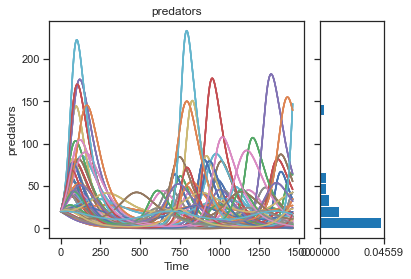

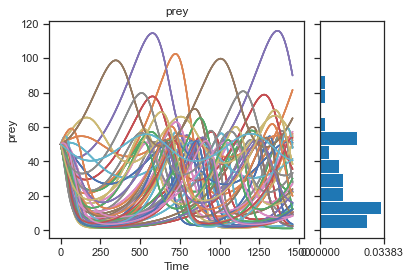

In [8]:
import matplotlib.pyplot as plt # TO DO; plot the scalers.
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
experiments, outcomes = results
# print(experiments.shape)
# print(list(outcomes.keys()))
# print(outcomes)
outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()}
# print(outcomes)

for outcome in outcomes.keys():
    print(outcome)
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting_util.Density.HIST)
plt.show()